In [1]:
from pystencils.session import *
sp.init_printing()
frac = sp.Rational

# Tutorial 06: Phase-field simulation of dentritic solidification

This is the second tutorial on phase field methods with pystencils. Make sure to read the previous tutorial first. 

In this tutorial we again implement a model described in **Programming Phase-Field Modelling** by S. Bulent Biner.
This time we implement the model from chapter 4.7 that describes dentritic growth. So get ready for some beautiful snowflake pictures.

We start again by adding all required arrays fields. This time we explicitly store the change of the phase variable φ in time, since the dynamics is calculated using an Allen-Cahn formulation where a term $\partial_t \phi$ occurs.

In [2]:
dh = ps.create_data_handling(domain_size=(300, 300), periodicity=True, 
                             default_target='cpu')
φ_field = dh.add_array('phi', latex_name='φ')
φ_delta_field = dh.add_array('phidelta', latex_name='φ_D')
t_field = dh.add_array('T')

This model has a lot of parameters that are created here in a symbolic fashion. 

In [3]:
ε, m, δ, j, θzero, α, γ, Teq, κ, τ = sp.symbols("ε m δ j θ_0 α γ T_eq κ τ")
εb = sp.Symbol("\\bar{\\epsilon}")

φ = φ_field.center
T = t_field.center

def f(φ, m):
    return φ**4 / 4 - (frac(1, 2) - m/3) * φ**3 + (frac(1,4)-m/2)*φ**2

free_energy_density = ε**2 / 2 * (ps.fd.Diff(φ,0)**2 + ps.fd.Diff(φ,1)**2 ) + f(φ, m)
free_energy_density

   4                                  2 ⎛         2            2⎞
φ_C       3 ⎛1   m⎞      2 ⎛1   m⎞   ε ⋅⎝D(φ[0,0])  + D(φ[0,0]) ⎠
──── - φ_C ⋅⎜─ - ─⎟ + φ_C ⋅⎜─ - ─⎟ + ────────────────────────────
 4          ⎝2   3⎠        ⎝4   2⎠                2              

The free energy is again composed of a bulk and interface part.

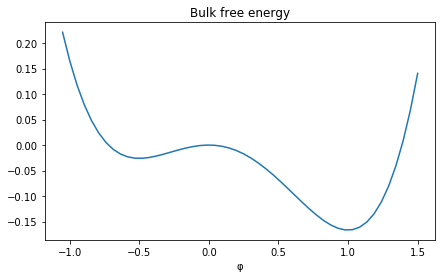

In [4]:
plt.figure(figsize=(7,4))
plt.sympy_function(f(φ, m=1), x_values=(-1.05, 1.5) )
plt.xlabel("φ")
plt.title("Bulk free energy");

Compared to last tutorial, this bulk free energy has also two minima, but at different values. 

Another complexity of the model is its anisotropy. The gradient parameter $\epsilon$ depends on the interface normal.

In [5]:
def σ(θ):
    return 1 + δ * sp.cos(j * (θ - θzero))

θ = sp.atan2(ps.fd.Diff(φ, 1), ps.fd.Diff(φ, 0))

ε_val = εb * σ(θ)
ε_val

\bar{\epsilon}⋅(δ⋅cos(j⋅(-θ₀ + atan2(D(φ[0,0]), D(φ[0,0])))) + 1)

In [6]:
def m_func(T):
    return (α / sp.pi) * sp.atan(γ * (Teq - T))

However, we just insert these parameters into the free energy formulation before doing the functional derivative, to make the dependence of $\epsilon$ on $\nabla \phi$ explicit.

In [7]:
fe = free_energy_density.subs({
    m: m_func(T),
    ε: εb * σ(θ),
})

dF_dφ = ps.fd.functional_derivative(fe, φ)
dF_dφ = ps.fd.expand_diff_full(dF_dφ, functions=[φ])
dF_dφ

          2                               2                                   
   3   φ_C ⋅α⋅atan(T_C⋅γ - T_eq⋅γ)   3⋅φ_C    φ_C⋅α⋅atan(T_C⋅γ - T_eq⋅γ)   φ_C
φ_C  - ─────────────────────────── - ────── + ────────────────────────── + ───
                    π                  2                  π                 2 

                                                                              
                 2  2    2                                                    
 - \bar{\epsilon} ⋅δ ⋅cos (j⋅θ₀ - j⋅atan2(D(φ[0,0]), D(φ[0,0])))⋅D(D(φ[0,0])) 
                                                                              

                                                                              
                2  2    2                                                     
- \bar{\epsilon} ⋅δ ⋅cos (j⋅θ₀ - j⋅atan2(D(φ[0,0]), D(φ[0,0])))⋅D(D(φ[0,0])) -
                                                                              

                                                 

Then we insert all the numeric parameters and discretize:

In [8]:
discretize = ps.fd.Discretization2ndOrder(dx=0.03, dt=1e-5)
parameters = {
    τ: 0.0003,
    κ: 1.8,
    εb: 0.01,
    δ: 0.02,
    γ: 10,
    j: 6,
    α: 0.9,
    Teq: 1.0,
    θzero: 0.2,
    sp.pi: sp.pi.evalf()
}
parameters

In [9]:
dφ_dt = - dF_dφ / τ
φ_eqs = ps.simp.sympy_cse_on_assignment_list([ps.Assignment(φ_delta_field.center, 
                                                            discretize(dφ_dt.subs(parameters)))])
φ_eqs.append(ps.Assignment(φ, discretize(ps.fd.transient(φ) - φ_delta_field.center)))

temperature_evolution = -ps.fd.transient(T) + ps.fd.diffusion(T, 1) + κ * φ_delta_field.center
temperature_eqs = [
    ps.Assignment(T, discretize(temperature_evolution.subs(parameters)))
]

When creating the kernels we pass as target (which may be 'cpu' or 'gpu') the default target of the target handling. This enables to switch to a GPU simulation just by changing the parameter of the data handling.

The rest is similar to the previous tutorial.

In [10]:
φ_kernel = ps.create_kernel(φ_eqs, cpu_openmp=4, target=dh.default_target).compile()
temperature_kernel = ps.create_kernel(temperature_eqs, target=dh.default_target).compile()

In [11]:
def timeloop(steps=200):
    φ_sync = dh.synchronization_function(['phi'])
    temperature_sync = dh.synchronization_function(['T'])
    dh.all_to_gpu()  # this does nothing when running on CPU
    for t in range(steps):
        φ_sync()
        dh.run_kernel(φ_kernel)
        temperature_sync()
        dh.run_kernel(temperature_kernel)
    dh.all_to_cpu()
    return dh.gather_array('phi')
    
def init(nucleus_size=np.sqrt(5)):
    for b in dh.iterate():
        x, y = b.cell_index_arrays
        x, y = x-b.shape[0]//2, y-b.shape[0]//2
        bArr = (x**2 + y**2) < nucleus_size**2
        b['phi'].fill(0)
        b['phi'][(x**2 + y**2) < nucleus_size**2] = 1.0
        b['T'].fill(0.0)
        
def plot():
    plt.subplot(1,3,1)
    plt.scalar_field(dh.gather_array('phi'))
    plt.title("φ")
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.title("T")
    plt.scalar_field(dh.gather_array('T'))
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.title("∂φ")
    plt.scalar_field(dh.gather_array('phidelta'))
    plt.colorbar()

    Name|      Inner (min/max)|     WithGl (min/max)
----------------------------------------------------
       T|            (  0,  0)|            (  0,  0)
     phi|            (  0,  1)|            (  0,  1)
phidelta|            (nan,nan)|            (nan,nan)



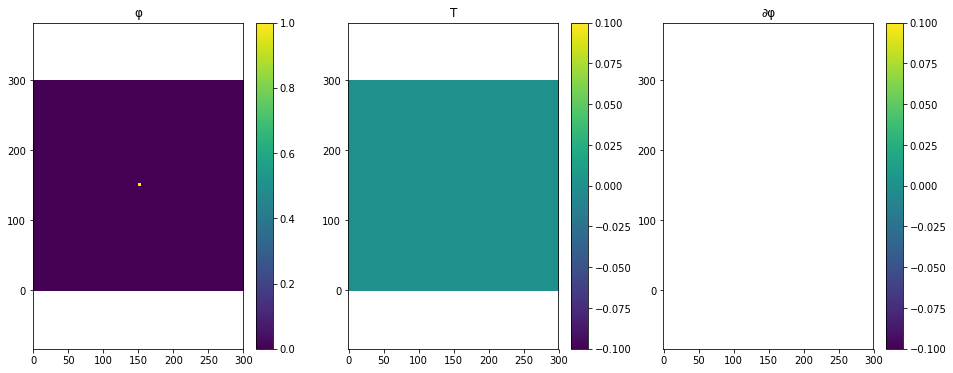

In [12]:
timeloop(10)
init()
plot()
print(dh)

In [13]:
result = None
if 'is_test_run' not in globals():
    ani = ps.plot.scalar_field_animation(timeloop, rescale=True, frames=600)
    result = ps.jupyter.display_as_html_video(ani)
result

In [14]:
assert np.isfinite(dh.max('phi'))
assert np.isfinite(dh.max('T'))